Чтобы решить проблему несбалансированных классов в нашем анализе обнаружения мошенничества, нам необходимо учитывать не только точность нашей модели, но и её отзыв, который измеряет, насколько часто модель правильно предсказывает мошенничество, когда оно действительно происходит.

Одним из способов улучшить запоминание является использование методов случайной выборки, таких как избыточная и недостаточная дискретизация. Избыточная выборка включает дублирование выборок из класса меньшинства, в то время как недостаточная выборка включает удаление выборок из класса большинства. Однако оба подхода имеют свои недостатки: избыточная дискретизация потенциально приводит к переобучению, а недостаточная – к потере важной информации.

## 0. Import libraries

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.preprocessing as preprocessing
from sklearn import linear_model
from sklearn.model_selection import cross_validate
import sklearn.model_selection
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import learning_curve
from sklearn.metrics import explained_variance_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn import metrics
from sklearn.feature_selection import RFE

## 1. Data preporation

In [55]:
df_train = pd.read_csv('../datasets/train_features.csv')
df_test = pd.read_csv('../datasets/test_features.csv')

df_train.drop(['Unnamed: 0'], axis=1, inplace=True)
df_test.drop(['Unnamed: 0'], axis=1, inplace=True)

### 1.1 Categorial Encoding

In [56]:
categories = ['category', 'merchant', 'state', 'job']

#### 1.1.1 Label Encoding

In [57]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

for category in categories:
    df_train[category] = label_encoder.fit_transform(df_train[category])
    df_test[category] = label_encoder.fit_transform(df_test[category])

df_train.head()

,age,amount(usd),hour_of_day,category,merchant,state,city_pop,job,is_fraud
0,35.0,4.97,0,8,514,27,3495,370,0
1,44.0,107.23,0,4,241,47,149,428,0
2,61.0,220.11,0,0,390,13,4154,307,0
3,56.0,45.00,0,2,360,26,1939,328,0
4,37.0,41.96,0,9,297,45,99,116,0


### 2. Model preparation

На этом этапе наша цель – сравнить точность и отзывчивость классификатора с различными методами выборки, включая обычную (без выборки), передискретизацию и недостаточную дискретизацию

#### 2.1 Train test split

In [58]:
y_train = df_train['is_fraud'].values
X_train = df_train.drop(['is_fraud'], axis='columns').values

y_test = df_test['is_fraud'].values
X_test = df_test.drop(['is_fraud'], axis='columns').values

In [59]:
# Data preprocessing to transfer all variables into array
scaler = preprocessing.StandardScaler()
vec = DictVectorizer(sparse=False)

In [60]:
def Data_preprocessing(X, y):
    #1. Numerical vars info vector
    X_dataFeatureCon = X
    X_dictCon = pd.DataFrame(X_dataFeatureCon.T).to_dict().values()

    #2. Keep a df of concat before scaling
    X_all = X_dataFeatureCon

    #3. Vectorizing and scaling the nummerical variablesinto range [-1;1]
    X_vec_con = vec.fit_transform(X_dictCon)
    X_vec_con = scaler.fit_transform(X_vec_con)
    X_vec = X_vec_con

    #4. Convert target ino array
    y_vec = y

    return X_vec, y_vec, X_all

In [61]:
#Apply the Data_preprocessing func on training set and testing set
X_train_vec, y_train_vec, X_train_frame = Data_preprocessing(X_train, y_train)
X_test_vec, y_test_vec, X_test_frame = Data_preprocessing(X_test, y_test)

In [62]:
print('X train shape is:', X_train_vec.shape)
print('X train DataFrame shape is:', X_train_frame.shape)
print('y train shape is:', y_train_vec.shape)
print('X test shape is:', X_test_vec.shape)
print('X test DataFrame shape is:', X_test_frame.shape)
print('y test shape is:', y_test_vec.shape)

X train shape is: (1296675, 8)
X train DataFrame shape is: (1296675, 8)
y train shape is: (1296675,)
X test shape is: (555719, 8)
X test DataFrame shape is: (555719, 8)
y test shape is: (555719,)


Затем мы применяем подход с недостаточной и избыточной выборками для создания двух новых наборов данных для моделирования. Концепция заключается в том, что мы можем использовать умеренную передискретизацию для класса меньшинства, что улучшает предвзятость к примерам класса меньшинства. В то же время мы также выполняем значительную заниженную выборку в классе большинства, чтобы уменьшить смещение в примерах класса большинства.

### 2.2 Under sampling and Over sampling

In [63]:
# Under sampling and Over sampling

df_all = df_train
df_target = df_train['is_fraud']

# 1. Create counts
count_class_0, count_class_1 = df_target.value_counts()
print(count_class_0)
print(count_class_1)

df_class_0 = df_all[df_all['is_fraud'] == 0]
df_class_1 = df_all[df_all['is_fraud'] == 1]

1289169
7506


Random under-sampling:
0    7506
1    7506
Name: is_fraud, dtype: int64


<AxesSubplot: title={'center': 'Count(target)'}>

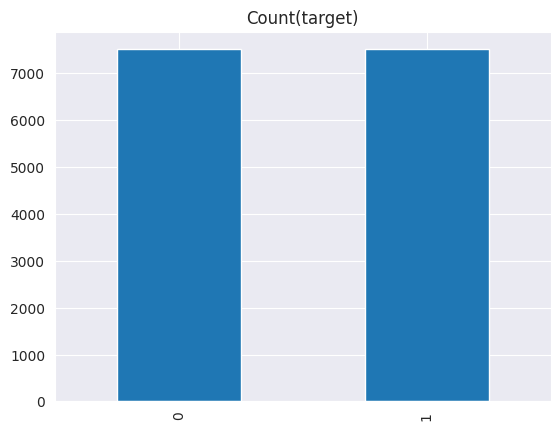

In [64]:
#2. Under sampling
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under['is_fraud'].value_counts())

df_test_under['is_fraud'].value_counts().plot(kind='bar', title='Count(target)')

Random over-sampling:
0    1289169
1    1289169
Name: is_fraud, dtype: int64


<AxesSubplot: title={'center': 'Count(target)'}>

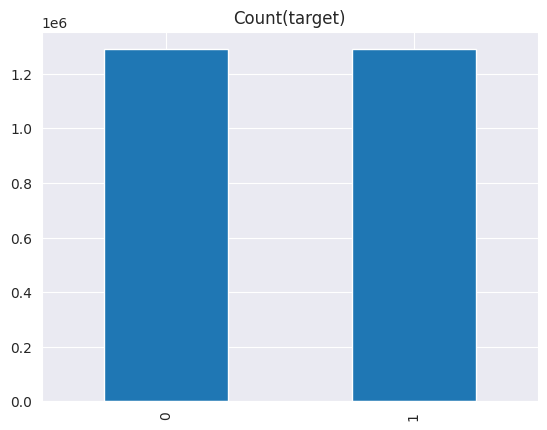

In [65]:
# 3. Over sampling
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over['is_fraud'].value_counts())

df_test_over['is_fraud'].value_counts().plot(kind='bar', title='Count(target)')

Теперь мы приступим к обучению наших моделей. Мы не будем передавать никаких параметров LogisticRegression() и примем параметры по умолчанию. Однако важно знать некоторые из важнейших параметров:

penalty: По умолчанию = L2 — задает норму для штрафа
C: Default = 1.0 — Обратная сила регуляризации
solver: Default = ‘lbfgs’ — Алгоритм оптимизации.
Вот реализация кода для обучения и тестирования моделей логистической регрессии.

Модель 1 — без какой-либо выборки с параметрами по умолчанию в логистической регрессии:

### 3. Modeling

#### 3.1 Simple log regresion

In [66]:
# Model 1
# 1. Model parameters
model1 = linear_model.LogisticRegression(C=1.0, penalty='l2', tol=1e-6)
model1.fit(X_train_vec, y_train_vec)

LogisticRegression(tol=1e-06)

In [67]:
#2. Accuracy score on testing set
y_pred = model1.predict(X_test_vec)
accuracy = accuracy_score(y_test_vec, y_pred)
print(accuracy*100)

99.54761309222827


In [68]:
#3. Confusion matrix
conf_mat = confusion_matrix(y_true=y_test_vec, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)

Confusion matrix:
 [[553205    369]
 [  2145      0]]


In [69]:
#4. Classification report
report = classification_report(y_test_vec, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.00      0.00      0.00      2145

    accuracy                           1.00    555719
   macro avg       0.50      0.50      0.50    555719
weighted avg       0.99      1.00      0.99    555719



#### 3.2 Strong reg

In [70]:
# Model2
#1. Get under sampling training set and testing set
df_u = df_test_under
df_u_target = df_u['is_fraud']
X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(df_u, df_u_target, test_size=0.2)

print(X_train_under.shape)
print(X_test_under.shape)
print(y_train_under.shape)
print(y_test_under.shape)

X_train_under_vec, y_train_under_vec, X_train_under_frame = Data_preprocessing(X_train_under, y_train_under)
X_test_under_vec, y_test_under_vec, X_test_under_frame = Data_preprocessing(X_test_under, y_test_under)

print('X train shape is:', X_train_under_vec.shape)
print('y train shape is:', y_train_under_vec.shape)
print('X test shape is:', X_test_under_vec.shape)
print('y test shape is:', y_test_under_vec.shape)

(12009, 9)
(3003, 9)
(12009,)
(3003,)
X train shape is: (12009, 9)
y train shape is: (12009,)
X test shape is: (3003, 9)
y test shape is: (3003,)


In [71]:
#2. Model parameters
model2 = linear_model.LogisticRegression(C=1.0, penalty='l2', tol=1e-6)
model2.fit(X_train_under_vec, y_train_under_vec)

LogisticRegression(tol=1e-06)

In [72]:
y_pred = model2.predict(X_test_under_vec)
accuracy = accuracy_score(y_test_under_vec, y_pred)
print(accuracy)

1.0


In [73]:
print(confusion_matrix(y_test_under_vec, y_pred))

[[1489    0]
 [   0 1514]]


In [74]:
print(classification_report(y_test_under_vec, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1489
           1       1.00      1.00      1.00      1514

    accuracy                           1.00      3003
   macro avg       1.00      1.00      1.00      3003
weighted avg       1.00      1.00      1.00      3003



Over

In [75]:
# Model2
#1. Get under sampling training set and testing set
df_u = df_test_over
df_u_target = df_u['is_fraud']
X_train_over, X_test_over, y_train_over, y_test_over = train_test_split(df_u, df_u_target, test_size=0.2)

print(X_train_over.shape)
print(X_test_over.shape)
print(y_train_over.shape)
print(y_test_over.shape)

X_train_over_vec, y_train_over_vec, X_train_over_frame = Data_preprocessing(X_train_over, y_train_over)
X_test_over_vec, y_test_over_vec, X_test_over_frame = Data_preprocessing(X_test_over, y_test_over)

print('X train shape is:', X_train_over_vec.shape)
print('y train shape is:', y_train_over_vec.shape)
print('X test shape is:', X_test_over_vec.shape)
print('y test shape is:', y_test_over_vec.shape)

ValueError: Found input variables with inconsistent numbers of samples: [2578338, 15012]

In [ ]:
df_test_over

In [ ]:
#2. Model parameters
model2 = linear_model.LogisticRegression(C=1.0, penalty='l2', tol=1e-6)
model2.fit(X_train_over_vec, y_train_over_vec)

In [ ]:
y_pred = model2.predict(X_test_over_vec)
accuracy = accuracy_score(y_test_over_vec, y_pred)
print(accuracy)

In [ ]:
print(confusion_matrix(y_test_over_vec, y_pred))

In [ ]:
print(classification_report(y_test_over_vec, y_pred))